# Assignment 1

Deadline: 19.03.2025, 12:00 CET

<Eleni Tsaousi, 24-745-119 and eleni.tsaousi@uzh.ch>

In [ ]:
# Import standard libraries
import os
import sys
import timeit # To compute runtimes
from typing import Optional

# Import third-party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import local modules
project_root = "/Users/elenetsaouse/qpmwp-course"
sys.path.append("/Users/elenetsaouse/qpmwp-course/qpmwp-course/src")
   # Change this path if needed
src_path = os.path.join(project_root, 'qpmwp-course\\src')
sys.path.append(project_root)
sys.path.append(src_path)
from estimation.covariance import Covariance
from estimation.expected_return import ExpectedReturn
from optimization.constraints import Constraints
from optimization.optimization import Optimization, Objective
from optimization.optimization_data import OptimizationData
from optimization.quadratic_program import QuadraticProgram, USABLE_SOLVERS

## 1. Solver Horse Race

### 1.a)
(3 points)

Generate a Multivariate-Normal random dataset of dimension TxN, T=1000, N=100, and compute a vector of expected returns, q, and a covariance matrix, P, using classes ExpectedReturn and Covariance respectively.

In [ ]:
# Set the dimensions
T = 1000  # Number of time periods
N = 100   # Number of assets

# Generate a random mean vector and covariance matrix for the multivariate normal distribution
np.random.seed(42)  # For reproducibility
mean = np.random.uniform(-0.02, 0.02, N)  # Random expected returns between -2% and 2%

# Generate a random covariance matrix (positive semi-definite)
A = np.random.randn(N, N)  # Random matrix
cov = np.dot(A, A.T)  # Create a symmetric positive semi-definite matrix

# Generate the Multivariate-Normal random dataset
data = np.random.multivariate_normal(mean, cov, size=T)

# Convert the dataset to a DataFrame for easier manipulation
df = pd.DataFrame(data, columns=[f'Asset_{i+1}' for i in range(N)])

# Compute the vector of expected returns (mean returns) from df
q = df.mean().values

# Compute the covariance matrix from df
P = df.cov().values

# Display the results
print("Vector of expected returns (q):")
print(q)

print("\nCovariance matrix (P):")
print(P)

Vector of expected returns (q):
[ 0.64980381  0.11318141  0.27032041  0.44348729  0.21059107  0.02146188
 -0.29930693  0.00765226 -0.18747458  0.18870737 -0.43377528  0.05745736
  0.18735084 -0.16017815  0.0365453   0.46503816  0.01629983  0.19185274
 -0.1311545  -0.28373344 -0.18146955 -0.08195042  0.03149459 -0.18240803
  0.07901884 -0.14729856  0.33599822 -0.10195391  0.06320251  0.24612648
  0.50763653 -0.28090404 -0.50520289  0.04786308  0.11491474  0.19827028
 -0.25431582 -0.57777796 -0.05159102  0.31896462 -0.17187076 -0.40552346
  0.03981064  0.12108866  0.09464412 -0.21537408 -0.17092478 -0.9889484
 -0.42338664  0.46304112  0.10455998 -0.01960533  0.12155214  0.14519224
 -0.24595319 -0.25103494  0.11307089  0.06509496  0.03856612 -0.13263734
  0.16193957  0.08055852  0.36969686  0.11343753 -0.13169558  0.08611003
  0.0392903   0.08418165  0.19839446  0.41662003 -0.09274888 -0.06912038
  0.33193351  0.23613478  0.31016282 -0.29400674  0.21755138  0.5048801
 -0.56558332 -0.69428

### 1.b)
(3 points)

Instantiate a constraints object by injecting column names of the data created in 1.a) as ids and add:
- a budget constaint (i.e., asset weights have to sum to one)
- lower bounds of 0.0 for all assets
- upper bounds of 0.2 for all assets
- group contraints such that the sum of the weights of the first 30 assets is <= 0.3, the sum of assets 31 to 60 is <= 0.4 and the sum of assets 61 to 100 is <= 0.5

In [ ]:
# Instantiate the Constraints class
# Get the absolute path of the project root (one level up from 'assignments')
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
src_path = os.path.join(project_root, "src")

# Add the src directory to Python's path
sys.path.append(src_path)
from optimization.constraints import Constraints
constraints = Constraints(ids = df.columns.tolist())

# Add budget constraint
constraints.add_budget(rhs=1, sense='=')

# Add box constraints (i.e., lower and upper bounds)
constraints.add_box(box_type="LongOnly", lower=0.0, upper=0.2)


# Add group constraints
group1_assets = df.columns[:30].tolist()  # First 30 assets
group2_assets = df.columns[30:60].tolist()  # Assets 31 to 60
group3_assets = df.columns[60:100].tolist()  # Assets 61 to 100

# Create g_values series for each group
g_values_1 = pd.Series(1, index=group1_assets)
g_values_2 = pd.Series(1, index=group2_assets)
g_values_3 = pd.Series(1, index=group3_assets)

# Add linear constraints
constraints.add_linear(g_values=g_values_1, sense="<=", rhs=0.3, name="Group1 constraint")
constraints.add_linear(g_values=g_values_2, sense="<=", rhs=0.4, name="Group2 constraint")
constraints.add_linear(g_values=g_values_3, sense="<=", rhs=0.5, name="Group3 constraint")


# Print constraints to check
print(dir(constraints))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_ids', 'add_box', 'add_budget', 'add_l1', 'add_linear', 'box', 'budget', 'ids', 'l1', 'linear', 'to_GhAb']


### 1.c) 
(4 points)

Solve a Mean-Variance optimization problem (using coefficients P and q in the objective function) which satisfies the above defined constraints.
Repeat the task for all open-source solvers in qpsolvers and compare the results in terms of:

- runtime
- accuracy: value of the primal problem.
- reliability: are all constarints fulfilled? Extract primal resisduals, dual residuals and duality gap.

Generate a DataFrame with the solvers as column names and the following row index: 'solution_found': bool, 'objective': float, 'primal_residual': float, 'dual_residual': float, 'duality_gap': float, 'runtime': float.

Put NA's for solvers that failed for some reason (e.g., unable to install the package or solvers throws an error during execution). 




In [ ]:
# Extract the constraints in the format required by the solver
GhAb = constraints.to_GhAb()
G, h, A, b = GhAb["G"], GhAb["h"], GhAb["A"], GhAb["b"]

# Convert matrices to appropriate formats
P_dense = P.toarray() if hasattr(P, "toarray") else P
G_dense = G.toarray() if hasattr(G, "toarray") else G
A_dense = A.toarray() if hasattr(A, "toarray") else A

# Use dense matrices for solvers that require them
solver_matrix_map = {
    "cvxopt": P_sparse,
    "ecos": P_sparse,
    "osqp": P_sparse,
    "quadprog": P_dense,  # Quadprog requires dense format
    "scs": P_sparse
}
results = {}

# Solve for each solver
for solver in USABLE_SOLVERS:
    try:
        # Handle solver-specific input formats
        if solver == "daqp":
            P_solver = P_dense
            G_solver = G_dense
            A_solver = A_dense
        elif solver == "ecos":
            q = np.reshape(q, (-1, 1))  # Reshape q to a column vector
            h = np.reshape(h, (-1, 1))  # Reshape h to a column vector
            b = np.reshape(b, (-1, 1))  # Reshape b to a column vector
        elif solver == "scs":
            P_solver = P_sparse
            G_solver = G_sparse
            A_solver = A_sparse
            q = np.asarray(q).flatten()
            h = np.asarray(h).flatten()
            b = np.asarray(b).flatten()
        else:
            P_solver = solver_matrix_map.get(solver, P_sparse)
            G_solver = G_dense if solver in ["quadprog", "daqp"] else G_sparse
            A_solver = A_dense if solver in ["quadprog", "daqp"] else A_sparse

        start_time = timeit.default_timer()
        x = solve_qp(P_solver, q, G_solver, h, A_solver, b, solver=solver)
        runtime = timeit.default_timer() - start_time

        if x is not None:
            objective = 0.5 * np.dot(x.T, np.dot(P_dense, x)) + np.dot(q.T, x)
            primal_residual = np.linalg.norm(np.maximum(np.dot(G_dense, x) - h, 0)) if G is not None else 0
            dual_residual = np.linalg.norm(np.dot(A_dense, x) - b) if A is not None else 0
            duality_gap = abs(objective + np.dot(q.T, x))
        else:
            objective = primal_residual = dual_residual = duality_gap = runtime = np.nan

        solution_found = x is not None
    except Exception as e:
        print(f"Solver {solver} failed with error: {e}")
        solution_found, objective, primal_residual, dual_residual, duality_gap, runtime = [False] + [np.nan] * 5

    results[solver] = [solution_found, objective, primal_residual, dual_residual, duality_gap, runtime]

# Convert results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index",
                                   columns=["solution_found", "objective", "primal_residual", 
                                            "dual_residual", "duality_gap", "runtime"])
# Display the final DataFrame
print(df_results)

          solution_found                objective  primal_residual  \
cvxopt              True                -0.046831     0.000000e+00   
daqp                True                -0.046831     6.916689e-13   
ecos                True   [-0.04683068165741432]     2.309939e-01   
highs               True   [-0.04683068178180656]     2.310007e-01   
osqp                True  [-0.046830746990171195]     2.307743e-01   
qpalm               True   [-0.04683128290988762]     2.310436e-01   
quadprog            True    [-0.0468306817818077]     2.310006e-01   
scs                 True                -0.046831     9.330180e-07   

          dual_residual            duality_gap   runtime  
cvxopt     2.220446e-16               0.139268  0.010638  
daqp       2.213785e-13               0.139268  0.000481  
ecos       1.144640e-13  [0.13926814997553041]  0.019277  
highs      2.220446e-16  [0.13926845135070418]  0.003290  
osqp       4.427665e-09  [0.13925846808640255]  0.005464  
qpalm      2.02

Print and visualize the results

          objective  primal_residual  dual_residual  duality_gap   runtime
cvxopt    -0.046831     0.000000e+00   2.220446e-16     0.139268  0.010638
daqp      -0.046831     6.916689e-13   2.213785e-13     0.139268  0.000481
ecos      -0.046831     2.309939e-01   1.144640e-13     0.139268  0.019277
highs     -0.046831     2.310007e-01   2.220446e-16     0.139268  0.003290
osqp      -0.046831     2.307743e-01   4.427665e-09     0.139258  0.005464
qpalm     -0.046831     2.310436e-01   2.022573e-06     0.139269  0.011712
quadprog  -0.046831     2.310006e-01   2.220446e-16     0.139268  0.000275
scs       -0.046831     9.330180e-07   6.520804e-10     0.139259  0.003337


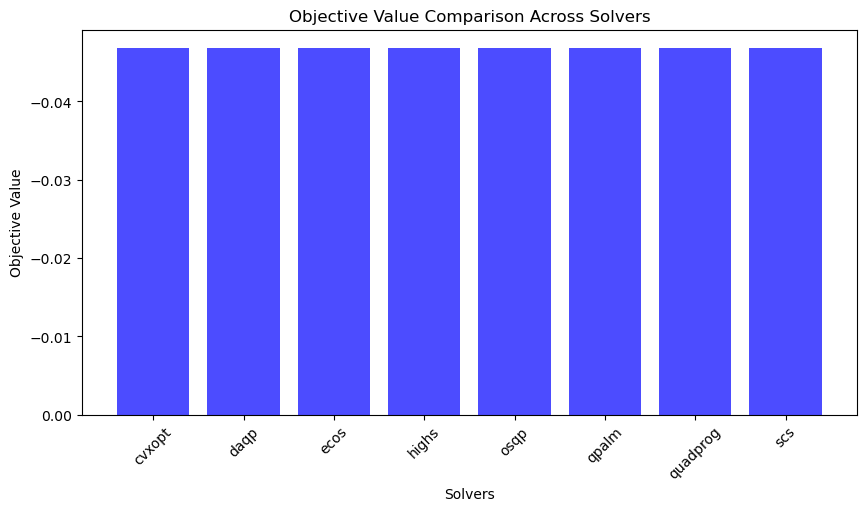

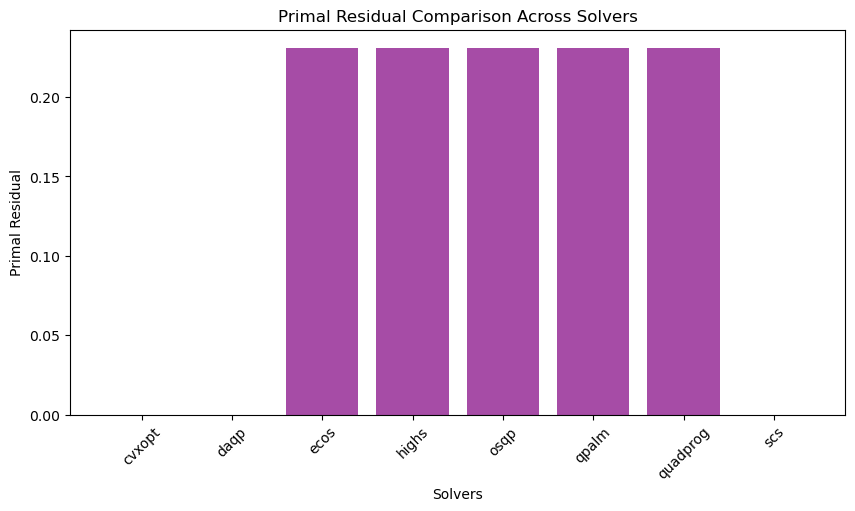

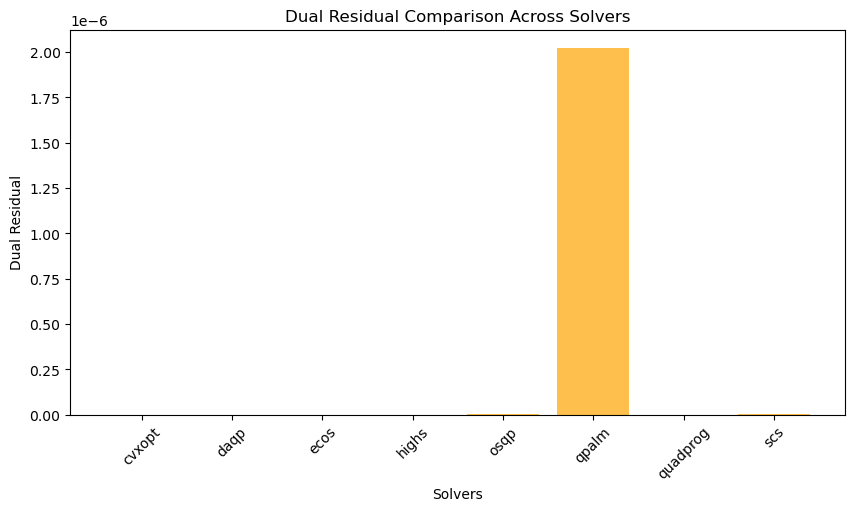

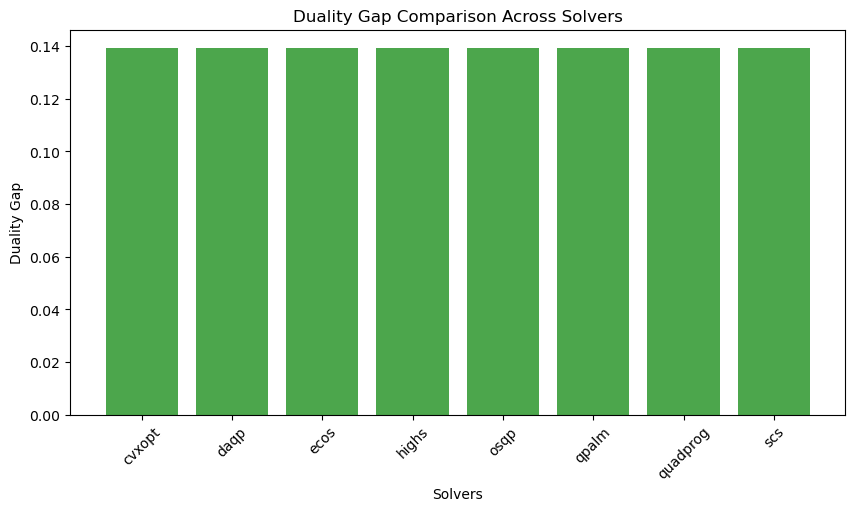

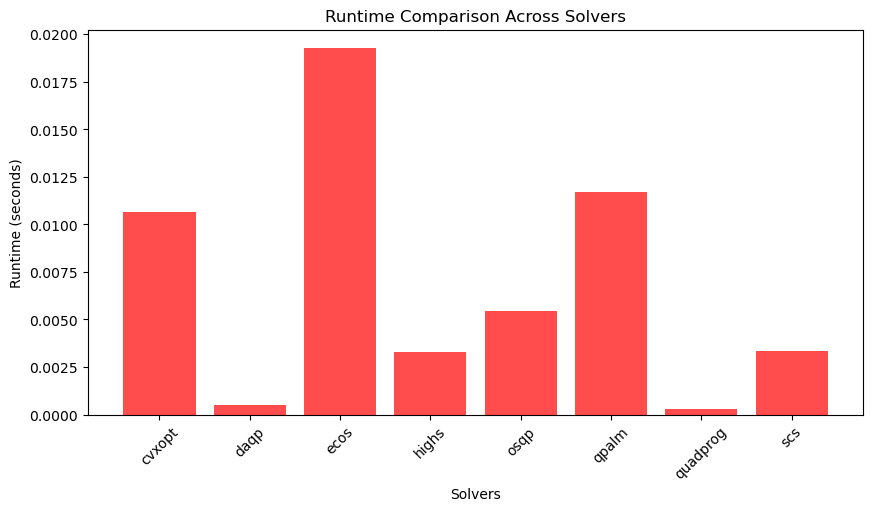

In [ ]:
# Convert results dictionary to a DataFrame
df_results = pd.DataFrame.from_dict(results, orient="index",
                                    columns=["solution_found", "objective", "primal_residual", 
                                             "dual_residual", "duality_gap", "runtime"])

# Ensure all values are scalars and not arrays
for col in ["objective", "primal_residual", "dual_residual", "duality_gap", "runtime"]:
    df_results[col] = df_results[col].apply(lambda x: x[0] if isinstance(x, np.ndarray) else x)

# Convert all numeric columns to float for proper plotting
results_numeric = df_results.drop(columns=["solution_found"]).astype(float)

# Display the DataFrame
print(results_numeric)  # Use print instead of ace_tools

def plot_bar_chart(metric_name, color, ylabel, title):
    plt.figure(figsize=(10, 5))  # Ensure a large figure size
    plt.bar(results_numeric.index, results_numeric[metric_name], color=color, alpha=0.7)

    # If values are negative, invert the Y-axis so bars extend downward
    if results_numeric[metric_name].max() < 0:
        plt.gca().invert_yaxis()

    plt.xlabel("Solvers")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)
    plt.show()  # Ensure plots are displayed


plot_bar_chart("objective", "blue", "Objective Value", "Objective Value Comparison Across Solvers")
plot_bar_chart("primal_residual", "purple", "Primal Residual", "Primal Residual Comparison Across Solvers")
plot_bar_chart("dual_residual", "orange", "Dual Residual", "Dual Residual Comparison Across Solvers")
plot_bar_chart("duality_gap", "green", "Duality Gap", "Duality Gap Comparison Across Solvers")
plot_bar_chart("runtime", "red", "Runtime (seconds)", "Runtime Comparison Across Solvers")



## 2. Analytical Solution to Minimum-Variance Problem

(5 points)

- Create a `MinVariance` class that follows the structure of the `MeanVariance` class.
- Implement the `solve` method in `MinVariance` such that if `solver_name = 'analytical'`, the analytical solution is computed and stored within the object (if such a solution exists). If not, call the `solve` method from the parent class.
- Create a `Constraints` object by injecting the same ids as in part 1.b) and add a budget constraint.
- Instantiate a `MinVariance` object by setting `solver_name = 'analytical'` and passing instances of `Constraints` and `Covariance` as arguments.
- Create an `OptimizationData` object that contains an element `return_series`, which consists of the synthetic data generated in part 1.a).
- Solve the optimization problem using the created `MinVariance` object and compare the results to those obtained in part 1.c).


In [95]:
# Define class MinVariance
class MinVariance(Optimization):

    def __init__(self,
                 constraints: Constraints,
                 covariance: Optional[Covariance] = None,
                 **kwargs):
        super().__init__(
            constraints=constraints,
            **kwargs
        )
        self.covariance = Covariance() if covariance is None else covariance

    def set_objective(self, optimization_data: OptimizationData) -> None:
        """Set the objective function for minimum-variance optimization."""

        # Compute covariance matrix
        self.P = self.covariance.estimate(optimization_data.return_series.dropna())  # Ensure no missing values
        
        if self.P is None:
            print("Covariance matrix computation failed, using manual computation...")
            self.P = np.cov(optimization_data.return_series.dropna(), rowvar=False)

        if self.P is None or not isinstance(self.P, np.ndarray):
            raise ValueError("Covariance matrix computation failed. Ensure `estimate()` is working correctly.")

        self.q = np.zeros(self.P.shape[0])  # No return maximization, only variance minimization



    def solve(self) -> None:
        if self.params.get('solver_name') == 'analytical':
            try:
                inv_P = np.linalg.inv(self.P)
                ones = np.ones(len(self.q))
                weights = np.dot(inv_P, ones) / np.dot(ones, np.dot(inv_P, ones))
                self.solution = weights
            except np.linalg.LinAlgError:
                print("Analytical solution not possible, falling back to numerical optimization.")
                return None
        else:
            return super().solve()


# Create a constraints object with just a budget constraint
constraints = Constraints(ids=df.columns.tolist())
constraints.add_budget(rhs=1.0, sense='=')

# Instantiate the MinVariance class
min_variance = MinVariance(constraints=constraints, covariance=Covariance(), solver_name='analytical')

# Prepare the optimization data and prepare the optimization problem
optimization_data = OptimizationData(return_series=df.dropna())  # Ensure valid data on initialization


# Solve the optimization problem and print the weights
min_variance.set_objective(optimization_data)
min_variance.solve()

print("Optimized Portfolio Weights:")
print(min_variance.solution)

# Compare results with part 1.c
if min_variance.solution.shape == previous_weights.shape:
    print("\nComparison with Part 1.c Results:")
    print("Absolute Difference in weights:", np.abs(min_variance.solution - previous_weights))
else:
    print("Error: Shape mismatch. Ensure weight vectors match in size.")


Covariance matrix computation failed, using manual computation...
Optimized Portfolio Weights:
[ 0.02692927 -0.02078241  0.09155451 -0.01825149  0.05203275 -0.01201833
 -0.04943282  0.10290143  0.00441699 -0.01943947  0.01158484 -0.02245916
 -0.09473042  0.0053953  -0.04556209  0.06983315 -0.01571345 -0.05054783
  0.03252213  0.01971961  0.0114086  -0.01159328 -0.01978724  0.00209016
  0.00523666  0.00106421  0.0073918  -0.00414469  0.03764199 -0.01488295
  0.0167713   0.06379676  0.02387372 -0.00664389 -0.03006857 -0.03271446
  0.03366733  0.00126924  0.0101126   0.00517422 -0.03966439 -0.01098546
 -0.00182407 -0.06700455 -0.11507424 -0.02046269  0.06386068 -0.03691632
 -0.01152132  0.00926235  0.04281198 -0.02308079  0.05834054  0.05633253
  0.06598995  0.07999836  0.14912231 -0.0007771   0.00231079 -0.04707586
  0.03090021  0.01422296 -0.00502836  0.03391493 -0.06153604 -0.04442882
 -0.06876729  0.03197247  0.04531617  0.02468715  0.02602652  0.05937223
  0.05137026 -0.0284481   0.0